# Game Music dataset: genre classification

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from ast import literal_eval
import os
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv('midi_dataframe.csv', parse_dates=[11])
# Cleaning
df.drop_duplicates(subset='file_name', inplace=True)
df.dropna(subset=['tgdb_genres'], inplace=True)
categories_filter = df.console.isin(['Medleys', 'Piano Only'])
remix_filter = df.title.str.contains('[Rr]emix')

df = df[~categories_filter & ~remix_filter]
df_stripped = df.copy()
df_stripped.title = df.title.str.replace('\(\d+\)', '').str.rstrip()
df_stripped['rank'] = df.title.str.extract('\((\d+)\)', expand=False)
df = df_stripped.sort_values(by='rank', ascending=False).groupby(['brand', 'console', 'game', 'title']).first().reset_index()
df.set_index('file_name', inplace=True)

In [3]:
num_games = len(df.groupby(['tgdb_platform', 'tgdb_gametitle']))
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(len(df),
        num_games,
        (df.tgdb_gametitle.notnull().sum())))
df_features = pd.read_csv('features.csv').set_index('file_name')
print("There is %d midi files with computed features"%(len(df_features)))

print("After removing not valid midi files, we have %d files"%(len(df.join(df_features, how='inner'))))

There is 22179 midi files, from 3243 games, with 22179 midis matched with tgdb
There is 31483 midi files with computed features
After removing not valid midi files, we have 22005 files


In [4]:
#df = pd.read_csv('midi_dataframe_cleaned.csv', parse_dates=[11])
#df.set_index('file_name', inplace=True)
df_genres = df.tgdb_genres.map(literal_eval, 'ignore').apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index().set_index('file_name')
df_genres.columns = ['genre']

# Problem statement

By joining the game music dataframe with the features dataset produced by JSimbolic, the final dataset to be used for the classification task is obtained.

This dataset provides 156 musical feature for each valid midi. 

In [5]:
df_pred = df_genres.join(df_features, how='inner').reset_index()
df_pred = df_pred.replace([np.inf, -np.inf], np.nan).dropna()
df_pred.head()

,file_name,genre,Prevalence_of_Most_Common_Pitch,Prevalence_of_Most_Common_Pitch_Class,Relative_Prevalence_of_Top_Pitches,Relative_Prevalence_of_Top_Pitch_Classes,Interval_Between_Most_Prevalent_Pitches,Interval_Between_Most_Prevalent_Pitch_Classes,Number_of_Common_Pitches,Pitch_Variety,...,Parallel_Motion,Similar_Motion,Contrary_Motion,Oblique_Motion,Parallel_Fifths,Parallel_Octaves,Dynamic_Range,Variation_of_Dynamics,Variation_of_Dynamics_In_Each_Voice,Average_Note_to_Note_Change_in_Dynamics
0,0004cc74bde3bc82f44afb5f566187c3dbcea9b2.mid,Platform,0.1593,0.2242,0.7222,0.7500,5.0,5.0,2.0,28.0,...,0.0000,0.0,0.0000,0.00000,0.0,0.0,63.0,17.65,6.3240,13.7800
1,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Action,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
2,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Adventure,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
3,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Sports,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
4,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Strategy,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128


To simplify this first analysis, only the five categories which are more represented in the dataset will be considered. 

These are Action, Role-Playing, Platform, Adventure, and Shooter.

In [6]:
df_pred = df_pred[(df_pred['genre'] == 'Action') | (df_pred['genre'] == 'Role-Playing') | (df_pred['genre'] == 'Platform') | (df_pred['genre'] == 'Adventure') | (df_pred['genre'] == 'Shooter')]
print("For this first analysis, 5 genres entailing " + str(df_pred.shape[0]) + " MIDIs will be considered.")

For this first analysis, 5 genres entailing 18569 MIDIs will be considered.


The dataset is divided into features and labels - X and y respectively - for the purpose of the classification task. The labels Y are mapped to integers to comply with the requirements of certain Machine Learning models such as linear regression.

In [7]:
X = df_pred.iloc[:, 2:]
y, y_string = pd.factorize(df_pred['genre'])

The dataset is split into training and testing sets with a 8-2 ratio, which seems very reasonable considering the size of the dataset.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=42)
print(str(X_train.shape[0]) + " MIDIs are used for training, " + str(X_test.shape[0]) + " are used for testing.")

14855 MIDIs are used for training, 3714 are used for testing.


# Models Evaluation

In this section various Machine Learning classification models are used with the goal of identifying the one who best fits the task. The models take as input the whole set of features and perform the classification task.

As a first approach, a logistic classifier is used.

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(solver='lbfgs', multi_class="multinomial", penalty="l2")
clf.fit(X_train, y_train)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print("The Logistic Regression classifier yields a score of " + str(train_score) + "on the training test " +
      " and of " + str(test_score) + " on the testing set")

0.44368899360484687
The Logistic Regression classifier yields a score of 0.43134087237479807


Since this linear model performs poorly for the given task, the more robust Random Forest and AdaBoost classifier (with decision trees as weak learners) are used. The parameters are chosen in order to make full use of the model without overloading it.

In [19]:
rfc = RandomForestClassifier(n_estimators=100, max_features = None, max_depth = 10, random_state = 1)
rfc.fit(X_train, y_train)

train_score = rfc.score(X_train, y_train)
test_score = rfc.score(X_test, y_test)

print("The Random Forest classifier yields a score of " + str(train_score) + "on the training test " +
      " and of " + str(test_score) + " on the testing set")

The Random Forest classifier yields a score of 0.7184786267250084on the training test  and of 0.39229940764674204 on the testing set


In [11]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
score = abc.score(X_test, y_test)

train_score = rfc.score(X_train, y_train)
test_score = rfc.score(X_test, y_test)

print("The Ada Boost classifier yields a score of " + str(train_score) + "on the training test " +
      " and of " + str(test_score) + " on the testing set")

The Ada Boost classifier yields a score of 0.4159935379644588


The accuracy of the classification didn't improve even by using these powerful ensemble methods.

These poor perfomance must be explained either by the data or by the models.

The failure of both linear and ensemble methods in delivering a satisfying result leads to investigate the data.

One valid hypothesis is that the data isn't linearly separable. If this were the case, then using a kernel could prove useful to make the data linearly separable.

To validate this assumption, the data is run on a kernelized Support Vectore Machine (SVM) model using the rbf kernel.

In [12]:
clf = SVC(kernel = 'rbf', gamma=1)
clf.fit(X_train, y_train) 
score = clf.score(X_test, y_test)

train_score = rfc.score(X_train, y_train)
test_score = rfc.score(X_test, y_test)

print("The kernelized SVC classifier yields a score of " + str(train_score) + "on the training test " +
      " and of " + str(test_score) + " on the testing set")

The kernelized SVC classifier yields a score of 0.2802907915993538


The performance is terrible, so this hypothesis isn't the right one.

Another possibility is that the features aren't informative enough. 

To get an idea of how informative the features ares, let's plot the feature\_importances\_ attribute of the Random Forest classifier.

Feature ranking:
1. feature 126 (0.048527)
2. feature 124 (0.026664)
3. feature 94 (0.025603)
4. feature 95 (0.021205)
5. feature 127 (0.018558)
6. feature 112 (0.014409)
7. feature 96 (0.012706)
8. feature 30 (0.010366)
9. feature 101 (0.010174)
10. feature 62 (0.010117)
11. feature 129 (0.009961)
12. feature 105 (0.009563)
13. feature 97 (0.009040)
14. feature 11 (0.009025)
15. feature 102 (0.008940)
16. feature 63 (0.008800)
17. feature 12 (0.008642)
18. feature 1 (0.008546)
19. feature 141 (0.008497)
20. feature 49 (0.008496)
21. feature 13 (0.008390)
22. feature 92 (0.008253)
23. feature 117 (0.008208)
24. feature 70 (0.008109)
25. feature 140 (0.008081)
26. feature 66 (0.008060)
27. feature 33 (0.008004)
28. feature 43 (0.007927)
29. feature 41 (0.007918)
30. feature 57 (0.007781)
31. feature 31 (0.007780)
32. feature 100 (0.007769)
33. feature 44 (0.007754)
34. feature 0 (0.007676)
35. feature 9 (0.007672)
36. feature 14 (0.007475)
37. feature 3 (0.007461)
38. feature 104 (0.007

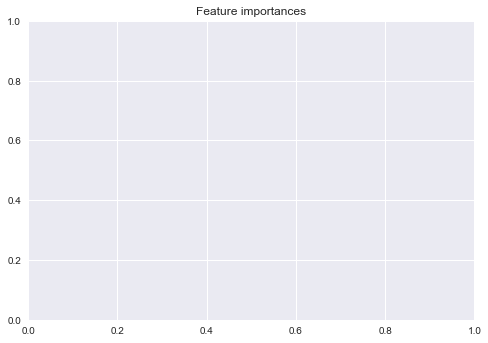

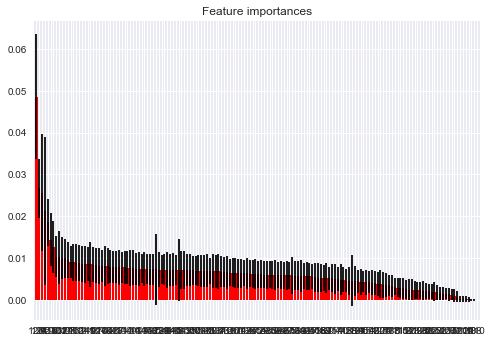

In [22]:
importances = rfc.feature_importances_

std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Let's try applying PCA to the features to see what happens.

In [14]:
pca = PCA(n_components=3)
pca.fit(X)
pca.explained_variance_ratio_

array([0.75146483, 0.12196016, 0.04089509])

The answer is very informative: the 1st principal component accounts for 75% of the variance in the dataset and the three first components account for 90%. This intuitevely means that the information relevant for the classification task tends to be centered towards determinate features, as opposed to being spread evenly in the dataset.

The next step is trying to identify these relevant features.

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(solver='lbfgs', multi_class="multinomial", penalty="l2")
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
clf.score(X_test, y_test)

0.44368899360484687


0.43134087237479807

In [16]:
best_features = np.take(df_pred.columns[2:], np.abs(clf.coef_).argsort()[:,-10:])
for i in range(len(y_string)):
    print("For class %s, best features:"%y_string[i])
    for feature in best_features[i]:
        print("  -", feature)

For class Platform, best features:
  - Variability_of_Note_Durations
  - Glissando_Prevalence
  - Amount_of_Arpeggiation
  - Stepwise_Motion
  - Average_Rest_Fraction_Per_Voice
  - String_Ensemble_Prevalence
  - Note_Density
  - Average_Number_of_Simultaneous_Pitch_Classes
  - Voice_Equality_-_Note_Duration
  - Variability_Across_Voices_of_Total_Rests_Per_Voice
For class Adventure, best features:
  - Importance_of_Bass_Register
  - Melodic_Perfect_Fifths
  - Variability_of_Number_of_Simultaneous_Pitch_Classes
  - Mean_Pitch
  - Average_Number_of_Simultaneous_Pitch_Classes
  - Prevalence_of_Most_Common_Melodic_Interval
  - Melodic_Thirds
  - Mean_Melodic_Interval
  - Average_Number_of_Independent_Voices
  - Amount_of_Arpeggiation
For class Role-Playing, best features:
  - Orchestral_Strings_Prevalence
  - String_Ensemble_Prevalence
  - Note_Density
  - Melodic_Thirds
  - Repeated_Notes
  - Variability_of_Note_Durations
  - Woodwinds_Prevalence
  - Partial_Chords
  - Voice_Equality_-_Not

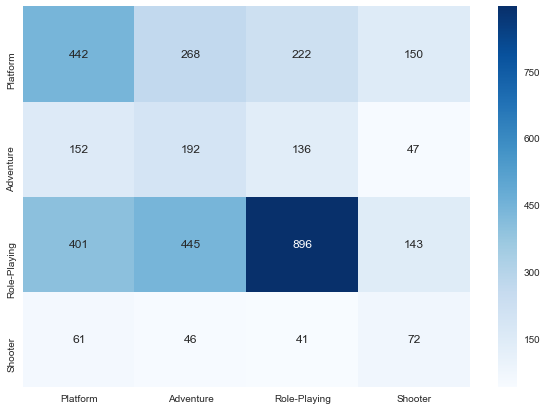

In [17]:
arr = confusion_matrix(clf.predict(X_test), y_test)
df_cm = pd.DataFrame(arr, index = [i for i in y_string],
                  columns = [i for i in y_string])
plt.figure(figsize = (10,7))
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()